In [1]:
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import logging

from datetime import timedelta

# Disable logging of the program in the notebook
os.environ["LOGLEVEL"] = "CRITICAL"

logging.basicConfig()
logging.root.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('__main__')
logger.setLevel(os.environ.get("LOGLEVEL", logging.FATAL))

pybooklogger = logging.getLogger('pybook')
pybooklogger.setLevel(logging.DEBUG)

from generation import generate
from parseRePEAT import *

In [2]:
def plot_atf(segments, axs, eatfs, **kwargs):
    color = kwargs.get('color', None)
    label = kwargs.get('label', None)
    y_offset = kwargs.get('y_offset', 0)
    line = None
    for (x0, x1, y0, y1) in segments:
        if x0 == "-inf" and x1 != "inf" and y1 != "inf":
            axs[0].hlines(float(y1) + y_offset, 0, float(x1), colors=color)
        line, = axs[0].plot([float(x0), float(x1)], [float(y0) + y_offset, float(y1) + y_offset], color=color)
    line.set_label(label) if line is not None else None

    plotted_intervals = []
    for path_eatf in eatfs.values():
        for (zeta, alpha, beta, delta, gammas) in path_eatf:
            min_gamma = 0
            max_gamma = 0
            for gamma_min, gamma_max, rt in gammas:
                # if gamma_max > gamma_min:
                #     raise ValueError(f"Max gamma > Min gamma, {gamma_max} > {gamma_min}")
                min_gamma += max(float(gamma_min) - float(rt), 0)
                max_gamma += max(float(gamma_max) - float(rt), 0)

            alpha = float(alpha)
            beta = float(beta)

            plotted_intervals.append((min(alpha, beta), beta, min_gamma, max_gamma))

            if alpha <= beta:
                # axs[1].plot([previous_beta, alpha], [min_gamma + y_offset, min_gamma + y_offset], color=color)
                axs[1].plot([alpha, beta], [min_gamma + y_offset, max_gamma + y_offset], color=color)
            # else:
            #     # axs[1].plot([previous_beta, beta - (gamma_diff)], [min_gamma + y_offset, min_gamma + y_offset], color=color)
            #     axs[1].plot([beta - (gamma_diff), beta], [min_gamma + y_offset, max_gamma + y_offset], color=color)
            # axs[1].plot([float(alpha), float(beta)], [min_gammas, max_gammas], color=color)
            previous_beta = beta

    previous_beta = 0
    plotted_intervals.sort(key=lambda x: x[0])

    for (alpha, beta, min_gamma, max_gamma) in plotted_intervals:
        axs[1].plot([previous_beta, alpha], [min_gamma + y_offset, min_gamma + y_offset], color=color)
        previous_beta = beta

            # pybooklogger.info(f"{alpha}, {beta}, {gammas}, {min_gammas} - {max_gammas}")

In [3]:
class Agent:
    def __init__(self, id, origin, destination, velocity, start_time):
        self.id = id
        self.origin = origin
        self.destination = destination
        self.velocity = velocity
        self.start_time = start_time

In [4]:
class Layout:
    def __init__(self, layout):
        self.g, self.g_block, self.g_duration, self.g_block_duration = generate.time_graph_creation(layout)

    def station_to_block(self, station, direction=0):
        if station in self.g_block.stations:
            if direction == "A":
                direction = 0
            if direction == "B":
                direction = 1
            return self.g_block.stations[station][direction]
        pybooklogger.error(f"Station {station} not found")
        return station

In [5]:
class Scenario:
    def __init__(self, l: Layout, scen_file, agent_id):
        self.l = l
        self.block_intervals, self.moves_per_agent, self.unsafe_computation_time, self.block_routes, self.t_moves_to_block = generate.time_scenario_creation(scen_file, self.l.g, self.l.g_block, agent_id)

    def get_flexibility(self, max_buffer_time, use_recovery_time):
        return generate.time_flexibility_creation(self.block_routes, self.block_intervals, max_buffer_time, use_recovery_time)

    def plot(self, agent_to_plot_route_of, buffer_times, recovery_times, plot_route_of_agent_to_plot_route_of=True):
        exclude_agent=-1
        if not plot_route_of_agent_to_plot_route_of:
            exclude_agent=agent_to_plot_route_of
        generate.plot_route(agent_to_plot_route_of, self.moves_per_agent, self.block_routes, self.block_intervals, self.l.g_block, buffer_times, recovery_times, exclude_agent=exclude_agent)

In [6]:
class Experiment:
    def __init__(self, s: Scenario, agent: Agent, max_buffer_time, use_recovery_time, metadata):
        self.s = s
        self.agent = agent
        self.metadata= metadata

        self.buffer_times, self.recovery_times, self.time_flexibility_creation = s.get_flexibility(max_buffer_time, use_recovery_time)
        self.safe_block_intervals, self.safe_block_edges_intervals, self.atfs, self.indices_to_states, self.safe_computation_time = generate.time_interval_creation(self.s.block_intervals, self.s.l.g_block, self.buffer_times, self.recovery_times, self.agent.destination, agent.velocity)
        self.results = None

    def run_search(self, timeout):
        file = "output"
        generate.write_intervals_to_file(file, self.safe_block_intervals, self.atfs, self.indices_to_states)
        try:
            proc = subprocess.run(["../search/buildDir/atsipp.exe", "--start", self.agent.origin, "--goal", self.agent.destination, "--edgegraph", file, "--search", "repeat", "--startTime", str(self.agent.start_time)], timeout=timeout, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)

        except subprocess.TimeoutExpired:
            pybooklogger.error(f'Timeout for repeat ({timeout}s) expired')
            return
        if int(proc.returncode) == 0:
            repeat_output = str(proc.stdout).split("'")[1].rsplit("\\r\\n")
            pybooklogger.debug(f"repeat output: {repeat_output}")
            metadata, catf, paths, eatfs = parse_list_of_outputs(repeat_output)
            pybooklogger.info(f"eats: {eatfs}")
            pybooklogger.info(f"cats: {catf}")
            self.results = (metadata, catf, paths, eatfs)


    def plot(self, axs, **kwargs):
        plot_atf(self.results[1], axs, self.results[3], label=self.metadata["label"], color=self.metadata["color"], y_offset=self.metadata["offset"], **kwargs)

    def get_running_time(self):
        return {
            "unsafe interval generation": self.s.unsafe_computation_time,
            "safe interval generation": self.safe_computation_time,
            "bt and crt generation": self.time_flexibility_creation,
            "converting routes to blocks": self.s.t_moves_to_block,
            "track graph creation": self.s.l.g_duration,
            "routing graph creation": self.s.l.g_block_duration,
            "FlexSIPP search time": float(self.results[0]["Search time"]) / 1000.0,
            "Lookup time": float(self.results[0]["Lookup time"]) / 1000.0,
        }

    def get_complexity(self):
        return {
            "nodes generated": int(self.results[0]["Nodes generated"]),
            "nodes decreased": int(self.results[0]["Nodes decreased"]),
            "nodes expanded": int(self.results[0]["Nodes expanded"]),
        }

In [7]:
def setup_plt(**kwargs):
    widths = [10]
    heights = [4, 1]
    fig, axs = plt.subplots(ncols=1, nrows=2, gridspec_kw={"height_ratios": heights, "width_ratios": widths})
    axs = axs.transpose()
    fig.set_figheight(7)
    fig.set_figwidth(15)

    axs[0].set_xlabel("Departure time (hh:mm:ss)")
    axs[1].set_xlabel("Departure time (hh:mm:ss)")
    axs[0].set_ylabel("Arrival time (hh:mm:ss)")
    axs[1].set_ylabel("Total delay of agents (s)")
    axs[0].set_title("Arrival Time Function")
    axs[0].set_xlim(left=kwargs.get("min_x", None), right=kwargs.get("max_x", None))
    axs[1].set_xlim(left=kwargs.get("min_x", None), right=kwargs.get("max_x", None))
    axs[0].set_ylim(bottom=kwargs.get("min_y", None), top=kwargs.get("max_y", None))
    axs[0].grid()
    axs[1].grid()

    axs[0].set_xticklabels([str(timedelta(seconds=xtick)) for xtick in axs[0].get_xticks()])
    axs[0].set_yticklabels([str(timedelta(seconds=ytick)) for ytick in axs[0].get_yticks()])
    axs[1].set_xticklabels([str(timedelta(seconds=xtick)) for xtick in axs[1].get_xticks()])

    return fig, axs

def plot_experiments(exps: list[Experiment], save_path=None, **kwargs):
    fig, axs = setup_plt(**kwargs)
    for e in exps:
        if e.results is None:
            pybooklogger.info(f"No results found, skipping {e}")
            continue
        pybooklogger.info(f"Plotting {e}")
        e.plot(axs, **kwargs)

    axs[0].legend()
    if save_path:
        fig.savefig(f"figures/{save_path}")
    plt.show()

In [8]:
def run_experiments(exps: list[Experiment], timeout):
    for e in exps:
        e.run_search(timeout)

In [9]:
default_settings = {
    "agent_id": -1,
    "origin": "ASD|13a",
    "destination": "RTD|2",
    "velocity": 140/3.6,
    "max_buffer_time": 0,
    "start_time": 0,
    "use_recovery_time": False,
    "metadata": {
        "color": "Red",
        "label": "No flexibility",
        "offset": 0,
    }
}

def _set_default(setting: dict, default: dict):
    for key, value in default.items():
        if key not in setting:
            setting[key] = value
        elif isinstance(value, dict):
            _set_default(setting[key], value)

def set_default(setting):
    _set_default(setting, default_settings)

In [10]:
def setup_experiment(layout, scenario_file, overwrite_settings):
    experiments = []
    scenarios = {}
    for exp in overwrite_settings:
        set_default(exp)
        origin = exp["origin"]
        destination = exp["destination"]
        velocity = exp["velocity"]
        start_time = exp["start_time"]
        agent_id = exp["agent_id"]
        max_buffer_time = exp["max_buffer_time"]
        use_recovery_time = exp["use_recovery_time"]
        metadata = exp["metadata"]

        pybooklogger.info(f"Setting up experiment {exp}")

        origin_signal = layout.station_to_block(origin)
        destination_signal = layout.station_to_block(destination)
        agent = Agent(agent_id, origin_signal, destination_signal, velocity, start_time)

        if agent_id not in scenarios:
            scenarios[agent_id] = Scenario(layout, scenario_file, agent_id)
            pybooklogger.debug(f"Created scenario {scenarios[agent_id]}")
        else:
            pybooklogger.debug(f"Using existing scenario {scenarios[agent_id]}")

        experiments.append(Experiment(scenarios[agent_id], agent, max_buffer_time, use_recovery_time, metadata))
    return experiments

In [11]:
layout_file =   "../data/prorail/parsed/netherlands-schiphol.json"
layout = Layout(layout_file)

In [12]:
scenario_file = "../data/prorail/scenarios/SHL-26-6-2025.json"

# Replan these agents, -1 is planning in a new agent

# Replan eurostar (first agent in SHL file)
experiment_settings = [
    {
        "agent_id": 1,
        "start_time": 1080,
        "origin": "SHL|6",
        "destination": "RTD|2",
        "metadata": {
            "offset": 2,
        }
    },
    {
        "agent_id": 1,
        "start_time": 1080,
        "max_buffer_time": 500,
        "origin": "SHL|6",
        "destination": "RTD|2",
        "metadata": {
            "color": "Green",
            "label": "Buffer time",
            "offset": 1,
        }
    },{
        "agent_id": 1,
        "start_time": 1080,
        "origin": "SHL|6",
        "destination": "RTD|2",
        "max_buffer_time": 500,
        "use_recovery_time": True,
        "metadata": {
            "color": "Blue",
            "label": "Recovery time",
        }
    }
]
experiments = setup_experiment(layout, scenario_file, experiment_settings)

INFO:pybook:Setting up experiment {'agent_id': 1, 'start_time': 1080, 'origin': 'SHL|6', 'destination': 'RTD|2', 'metadata': {'offset': 2, 'color': 'Red', 'label': 'No flexibility'}, 'velocity': 38.888888888888886, 'max_buffer_time': 0, 'use_recovery_time': False}
DEBUG:pybook:Created scenario <__main__.Scenario object at 0x00000230C51506D0>
INFO:pybook:Setting up experiment {'agent_id': 1, 'start_time': 1080, 'max_buffer_time': 500, 'origin': 'SHL|6', 'destination': 'RTD|2', 'metadata': {'color': 'Green', 'label': 'Buffer time', 'offset': 1}, 'velocity': 38.888888888888886, 'use_recovery_time': False}
DEBUG:pybook:Using existing scenario <__main__.Scenario object at 0x00000230C51506D0>
INFO:pybook:Setting up experiment {'agent_id': 1, 'start_time': 1080, 'origin': 'SHL|6', 'destination': 'RTD|2', 'max_buffer_time': 500, 'use_recovery_time': True, 'metadata': {'color': 'Blue', 'label': 'Recovery time', 'offset': 0}, 'velocity': 38.888888888888886}
DEBUG:pybook:Using existing scenario <

C:\Users\erick\Documents\uni\Thesis\delay-replannning\generation\safe_interval_graph.py:136: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(timedelta(seconds=ytick)) for ytick in ax.get_yticks()])


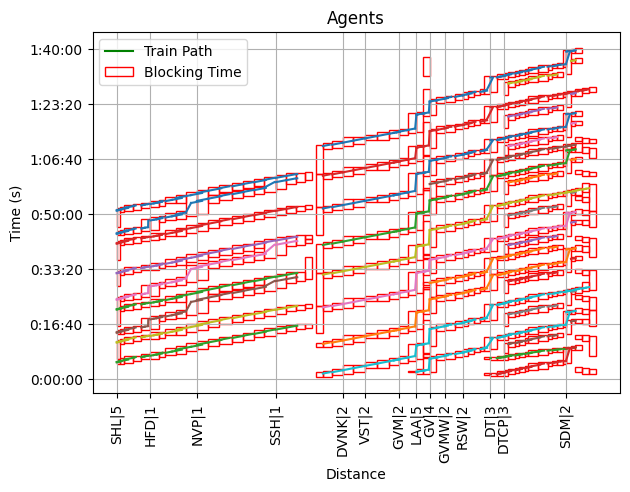

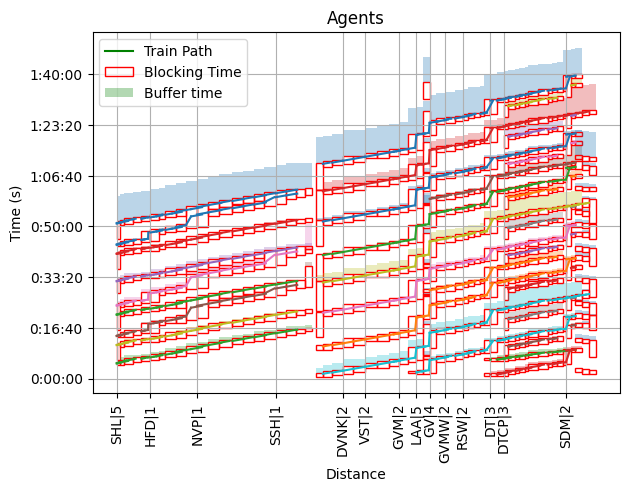

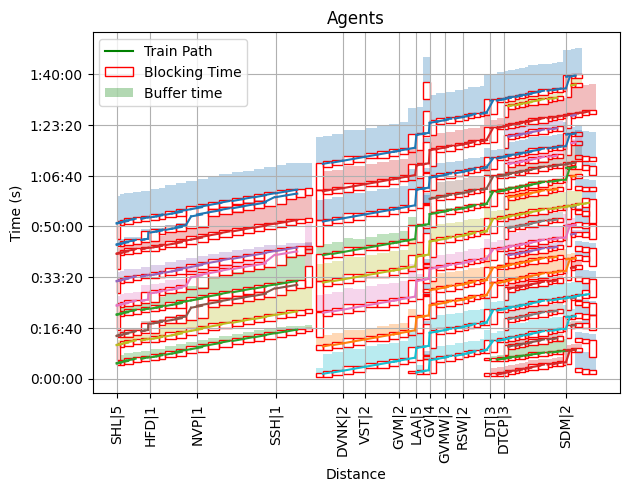

In [13]:
for exp in experiments:
    exp.s.plot(1, exp.buffer_times, exp.recovery_times, False)

In [14]:
timeout = 600
run_experiments(experiments, timeout)

DEBUG:pybook:repeat output: ['<0,inf,inf,inf> <-inf,1672.78,4417.17,4417.17>', '<1672.78,inf,inf,inf> <-inf,2750.88,5377.17,5377.17>', '<2750.88,inf,inf,inf> <-inf,3675.93,5377.17,5377.17>', '<-inf,2750.88,5377.17,5377.17> <-inf,3675.93,5377.17,5377.17>', '<3675.93,inf,inf,inf> <-inf,3701.11,5588.16,5588.16>', '<2750.88,3675.93,5377.17,5377.17> <-inf,3701.11,5588.16,5588.16>', '<-inf,2750.88,5377.17,5377.17> <-inf,2750.88,5588.16,5588.16>', '<3701.11,inf,inf,inf> <-inf,3947.03,5917.17,5917.17>', '<3675.93,3701.11,5588.16,5588.16> <-inf,3947.03,5917.17,5917.17>', '<2750.88,3675.93,5377.17,5377.17> <-inf,3675.93,5917.17,5917.17>', '<-inf,2750.88,5377.17,5377.17> <-inf,2750.88,5917.17,5917.17>', '<3947.03,inf,inf,inf> <-inf,4238.41,5917.25,5917.25>', '<3701.11,3947.03,5917.17,5917.17> <-inf,4238.41,5917.25,5917.25>', '<3675.93,3701.11,5588.16,5588.16> <-inf,3701.11,5917.25,5917.25>', '<2750.88,3675.93,5377.17,5377.17> <-inf,3675.93,5917.25,5917.25>', '<-inf,2750.88,5377.17,5377.17> <-inf,

C:\Users\erick\AppData\Local\Temp\ipykernel_21292\3836008885.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([str(timedelta(seconds=xtick)) for xtick in axs[0].get_xticks()])
C:\Users\erick\AppData\Local\Temp\ipykernel_21292\3836008885.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([str(timedelta(seconds=ytick)) for ytick in axs[0].get_yticks()])
C:\Users\erick\AppData\Local\Temp\ipykernel_21292\3836008885.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels([str(timedelta(seconds=xtick)) for xtick in axs[1].get_xticks()])


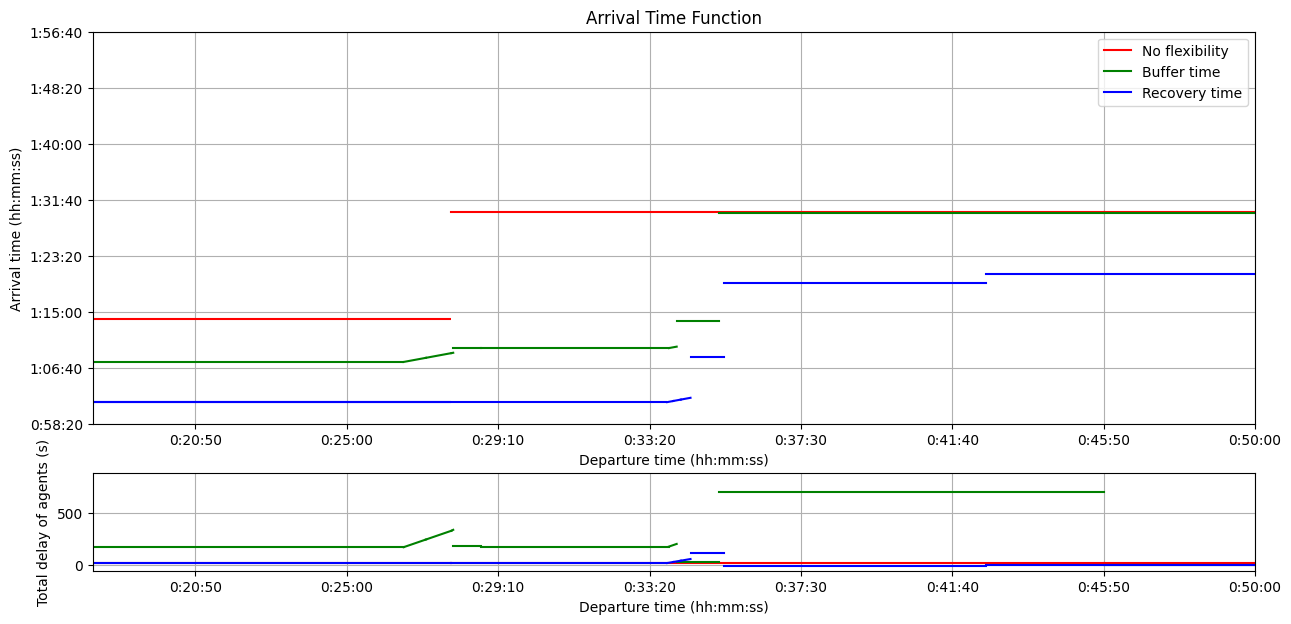

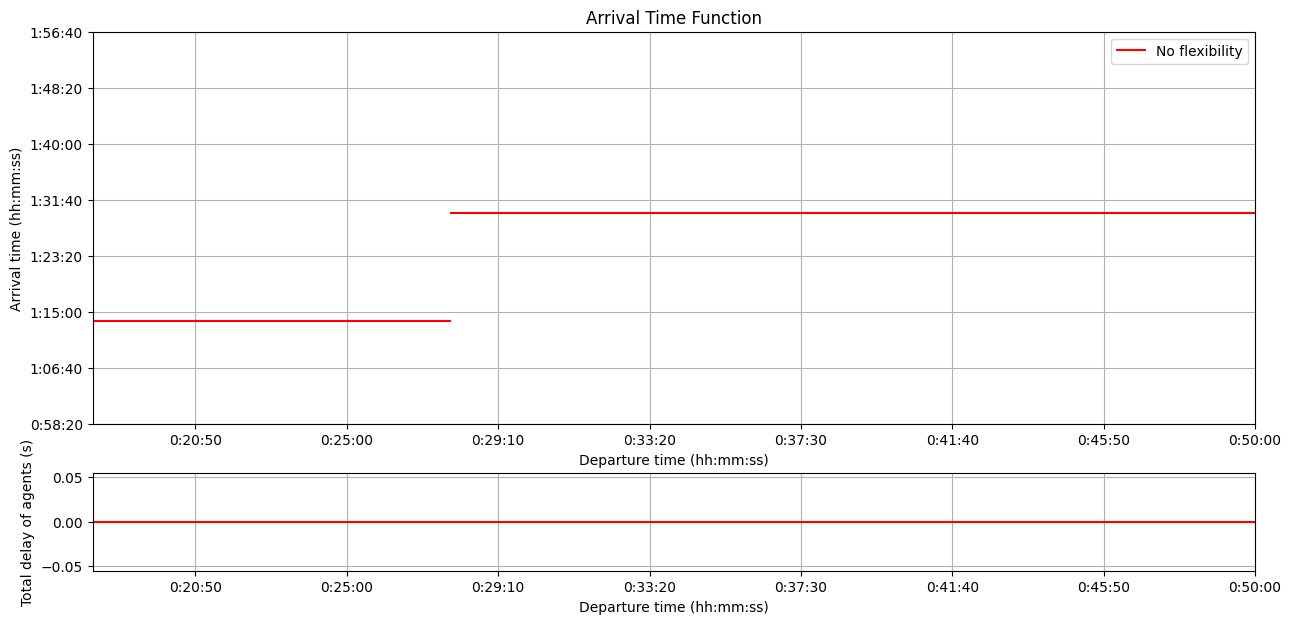

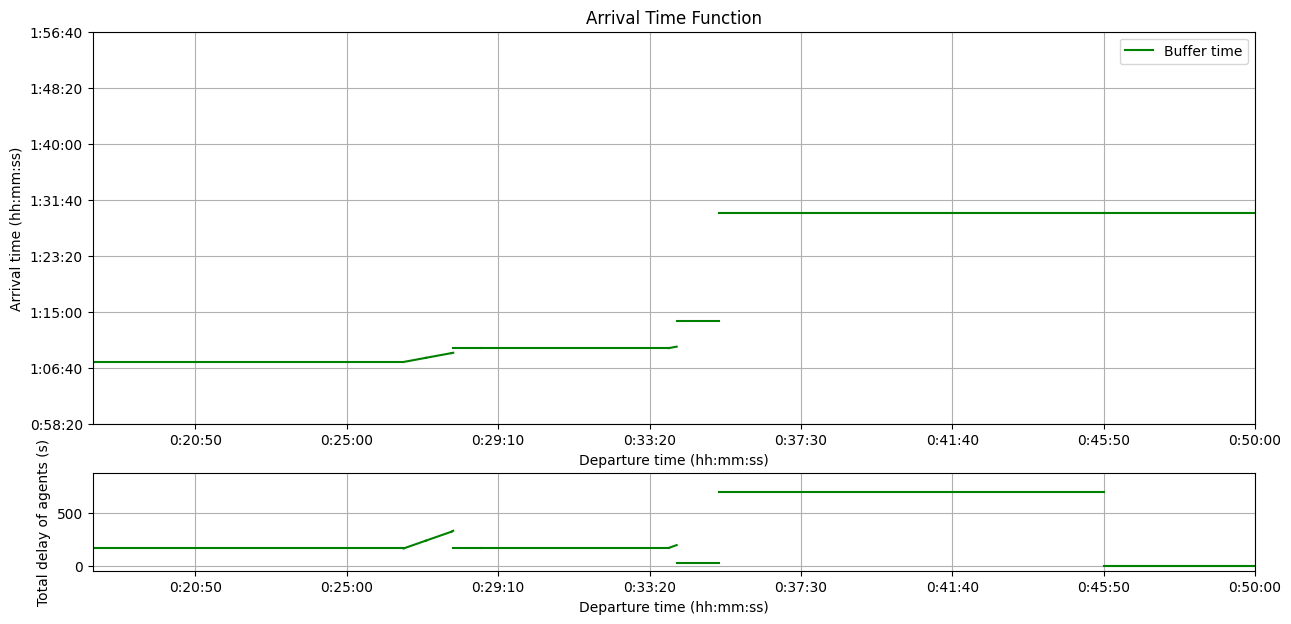

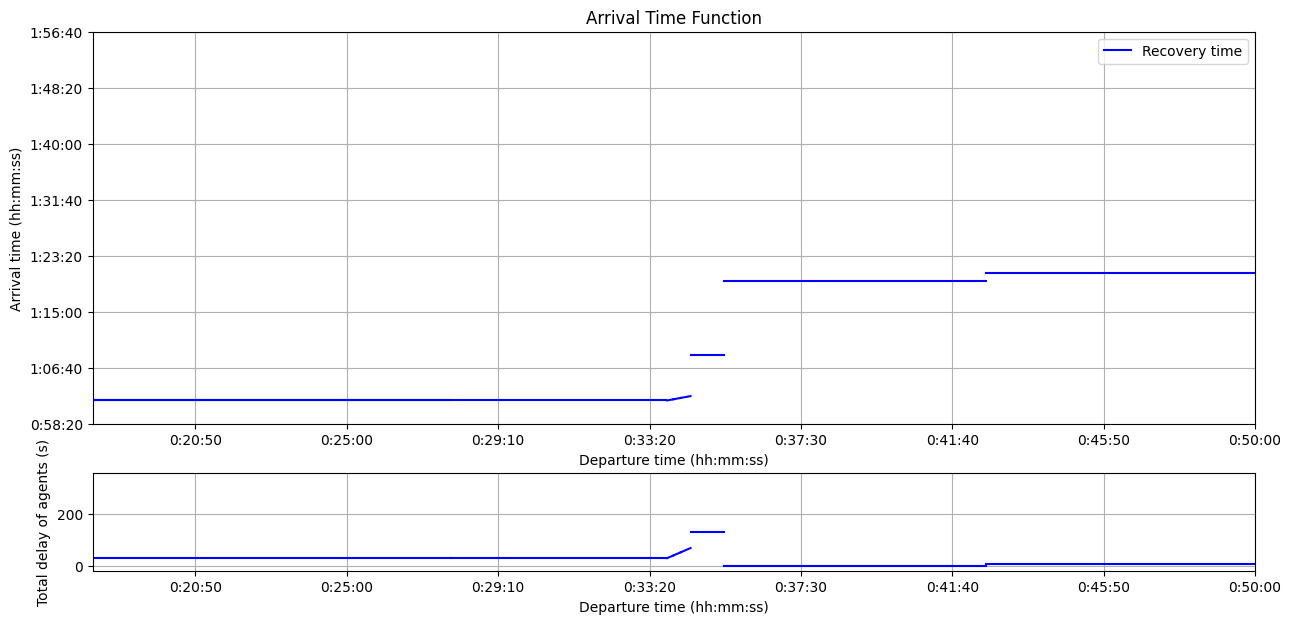

In [15]:
pybooklogger.setLevel(logging.WARNING)
experiments[0].metadata = {'color': 'Red', 'label': 'No flexibility', 'offset': 15}
experiments[1].metadata = {'color': 'Green', 'label': 'Buffer time', 'offset': 0}
experiments[2].metadata = {'color': 'Blue', 'label': 'Recovery time', 'offset': -15}
experiments[0].results[1][1] = ('1672.78', '2750.88', '5377.17', '5377.17')

kwargs = {"min_x": 1080, "max_x": 3000, "min_y": 3500, "max_y": 7000}
plot_experiments(experiments, **kwargs)


experiments[0].metadata = {'color': 'Red', 'label': 'No flexibility', 'offset': 0}
experiments[1].metadata = {'color': 'Green', 'label': 'Buffer time', 'offset': 0}
experiments[2].metadata = {'color': 'Blue', 'label': 'Recovery time', 'offset': 0}

plot_experiments([experiments[0]], **kwargs)
plot_experiments([experiments[1]], **kwargs)
plot_experiments([experiments[2]], **kwargs)

In [16]:
def sum_cols(df1, cols, name):
    df2 = df1.drop(columns=cols)
    df2[name] = df1[cols].sum(axis=1)
    return df2

time_df = pd.DataFrame([exp.get_running_time() for exp in experiments], index=[exp.metadata['label'] for exp in experiments])

setup_cols = ["track graph creation", "routing graph creation"]
recompute_cols = ["unsafe interval generation", "safe interval generation", "bt and crt generation", "converting routes to blocks"]
search_cols = ["FlexSIPP search time"]

time_df = sum_cols(time_df, setup_cols, "Setup Time")
time_df = sum_cols(time_df, recompute_cols, "Recompute Time")
time_df = sum_cols(time_df, search_cols, "Search Time")

print(time_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Lookup time &  Setup Time &  Recompute Time &  Search Time \\
\midrule
No flexibility &          6.5 &   65.969594 &      256.502735 &       35.407 \\
Buffer time    &          6.3 &   65.969594 &      256.515766 &      192.938 \\
Recovery time  &          6.7 &   65.969594 &      256.687366 &      170.502 \\
\bottomrule
\end{tabular}



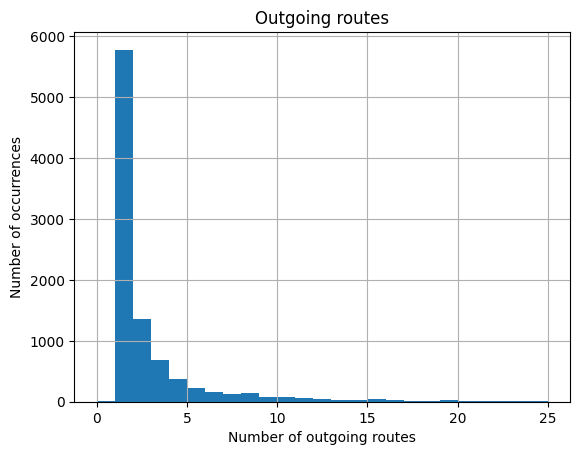

In [17]:
edges_df = pd.DataFrame({"Outgoing routes": [len(n.outgoing) for n in layout.g_block.nodes.values() if len(n.outgoing) <= 25]})
hist = edges_df.hist(bins=25, )
plt.xlabel("Number of outgoing routes")
plt.ylabel("Number of occurrences")
plt.show()

In [18]:
nodes_df = pd.DataFrame([exp.get_complexity() for exp in experiments], index=[exp.metadata['label'] for exp in experiments])

print(nodes_df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  nodes generated &  nodes decreased &  nodes expanded \\
\midrule
No flexibility &             1615 &              345 &            1057 \\
Buffer time    &             5300 &             4516 &            3087 \\
Recovery time  &             5806 &             5099 &            3582 \\
\bottomrule
\end{tabular}

